In [1]:
import matplotlib.pyplot as plt
from osgeo import gdal, osr, ogr
import numpy as np
from scipy.interpolate import griddata

## TASKS!
- ~~crop out AOI in ice mask based on lat lon~~
- ~~combine mask and coherence~~

## Functions

In [2]:
def get_tif_corners(tif_path):
    '''https://nsidc.org/support/faq/how-can-i-reproject-geotiff-file-polar-stereographic-projecton-geographic-latlon'''
    ds=gdal.Open(tif_path)

    gt=ds.GetGeoTransform()
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    ext=GetExtent(gt,cols,rows)

    src_srs=osr.SpatialReference()
    src_srs.ImportFromWkt(ds.GetProjection())
    #tgt_srs=osr.SpatialReference()
    #tgt_srs.ImportFromEPSG(4326)
    tgt_srs = src_srs.CloneGeogCS()
    geo_ext = np.array(ReprojectCoords(ext, src_srs, tgt_srs))
    return geo_ext


def load_tif_as_array(tiff_file):
    '''https://gis.stackexchange.com/questions/154669/editing-tiff-rasters-in-python/285685#285685'''
    geotransform = tiff_file.GetGeoTransform()
    projection = tiff_file.GetProjection()
    band = tiff_file.GetRasterBand(1)    
    xsize = band.XSize
    ysize = band.YSize
    array = band.ReadAsArray()
    tiff_file = None #close it
    band = None #close it
    return array


def GetExtent(gt,cols,rows):
    ''' Return list of corner coordinates from a geotransform

        @type gt:   C{tuple/list}
        @param gt: geotransform
        @type cols:   C{int}
        @param cols: number of columns in the dataset
        @type rows:   C{int}
        @param rows: number of rows in the dataset
        @rtype:    C{[float,...,float]}
        @return:   coordinates of each corner
    '''
    ext=[]
    xarr=[0,cols]
    yarr=[0,rows]

    for px in xarr:
        for py in yarr:
            x=gt[0]+(px*gt[1])+(py*gt[2])
            y=gt[3]+(px*gt[4])+(py*gt[5])
            ext.append([x,y])
            print(x,y)
        yarr.reverse()
    return ext

def ReprojectCoords(coords,src_srs,tgt_srs):
    ''' Reproject a list of x,y coordinates.

        @type geom:     C{tuple/list}
        @param geom:    List of [[x,y],...[x,y]] coordinates
        @type src_srs:  C{osr.SpatialReference}
        @param src_srs: OSR SpatialReference object
        @type tgt_srs:  C{osr.SpatialReference}
        @param tgt_srs: OSR SpatialReference object
        @rtype:         C{tuple/list}
        @return:        List of transformed [[x,y],...[x,y]] coordinates
    '''
    trans_coords=[]
    transform = osr.CoordinateTransformation( src_srs, tgt_srs)
    for x,y in coords:
        x,y,z = transform.TransformPoint(x,y)
        trans_coords.append([x,y])
    return trans_coords

## Paths

In [3]:
promice_mask_path = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/PROMICE_icemask_100_AndersKusk/PROMICE_icemask_100.tif'
coherence_path_1 = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/coherence/Coher_20170715_20170721_5_1_1_1_ortho.tif'
coherence_path_2 = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/coherence/Coher_20170709_20170715_5_1_1_1_ortho.tif'

## LOAD ICE MASK
https://gis.stackexchange.com/questions/154669/editing-tiff-rasters-in-python/285685#285685

Change map projection from polar stereographic (easting, northing) to WGS84

In [5]:
# # Change the following variables to the file you want to convert (inputfile)
# # and what you want to name your output file (outputfile)
# inputfile = promice_mask_path
# outputfile = "./output.tif"
# 
# #Do not change the following line, it will reproject the geotiff file
# ds = gdal.Warp(outputfile, inputfile, dstSRS="+proj=longlat +datum=WGS84 +no_defs")

In [4]:
#1.    
promice_mask_path_wgs = gdal.Open("./output.tif")

coherence_1 = load_tif_as_array(gdal.Open(coherence_path_1))
coherence_2 = load_tif_as_array(gdal.Open(coherence_path_2))

In [10]:
#2.
ice_mask = load_tif_as_array(promice_mask_path_wgs)

In [11]:
ds=promice_mask_path_wgs

gt=ds.GetGeoTransform()
cols = ds.RasterXSize
rows = ds.RasterYSize
ext=GetExtent(gt,cols,rows)

src_srs=osr.SpatialReference()
src_srs.ImportFromWkt(ds.GetProjection())
#tgt_srs=osr.SpatialReference()
#tgt_srs.ImportFromEPSG(4326)
tgt_srs = src_srs.CloneGeogCS()

ice_mask_geo_ext = np.array(ReprojectCoords(ext,src_srs,tgt_srs))

-88.2321458827168 83.79304220782258
-88.2321458827168 59.05718790265989
6.598793259421129 59.05718790265989
6.598793259421129 83.79304220782258


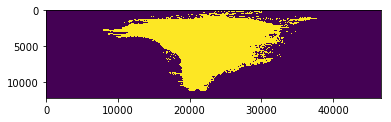

In [12]:
plt.imshow(ice_mask)

#### Manually found AOI

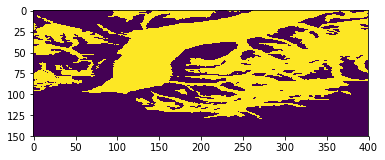

In [13]:
plt.imshow(ice_mask[5850:6000,17500:17900])  # [5000:6500,16500:18500] -> [5800:6200,17450:18100]

In [14]:
ds=gdal.Open(coherence_path_1)

gt=ds.GetGeoTransform()
cols = ds.RasterXSize
rows = ds.RasterYSize
ext=GetExtent(gt,cols,rows)

src_srs=osr.SpatialReference()
src_srs.ImportFromWkt(ds.GetProjection())
#tgt_srs=osr.SpatialReference()
#tgt_srs.ImportFromEPSG(4326)
tgt_srs = src_srs.CloneGeogCS()

coh_geo_ext=np.array(ReprojectCoords(ext, src_srs, tgt_srs))

-52.63382312509018 71.71839929656618
-52.63382312509018 71.58366325453392
-51.943083485575265 71.58366325453392
-51.943083485575265 71.71839929656618


In [15]:
coh_lon_min, coh_lon_max = np.min(coh_geo_ext[:, 0]), np.max(coh_geo_ext[:, 0])

In [16]:
coh_lat_min, coh_lat_max = np.min(coh_geo_ext[:, 1]), np.max(coh_geo_ext[:, 1])

In [17]:
ice_mask_geo_ext

array([[-88.23214588,  83.79304221],
       [-88.23214588,  59.0571879 ],
       [  6.59879326,  59.0571879 ],
       [  6.59879326,  83.79304221]])

In [18]:
ice_mask_latitudes = np.linspace(ice_mask_geo_ext[:, 1].max(), ice_mask_geo_ext[:, 1].min(), ice_mask.shape[0])

In [19]:
ice_mask_longitudes = np.linspace(ice_mask_geo_ext[:, 0].min(), ice_mask_geo_ext[:, 0].max(), ice_mask.shape[1])

In [20]:
indices_lat = np.squeeze(np.where(np.logical_and(coh_lat_min <= ice_mask_latitudes, ice_mask_latitudes <= coh_lat_max)))

In [21]:
indices_lon = np.squeeze(np.where(np.logical_and(coh_lon_min <= ice_mask_longitudes, ice_mask_longitudes <= coh_lon_max)))

In [22]:
ice_mask_aoi = ice_mask[indices_lat[:, None], indices_lon]

### Interpolate mask to coherence grid

In [23]:
ice_mask_latitudes_aoi = ice_mask_latitudes[indices_lat]
ice_mask_longitudes_aoi = ice_mask_longitudes[indices_lon]

In [24]:
ice_mask_lon_grid, ice_mask_lat_grid  = np.meshgrid(ice_mask_longitudes_aoi, ice_mask_latitudes_aoi)

In [25]:
ice_mask_lat_grid.shape, ice_mask_lon_grid.shape, ice_mask_aoi.shape

((66, 339), (66, 339), (66, 339))

In [26]:
ice_mask_lat_flat = ice_mask_lat_grid.flatten()
ice_mask_lon_flat = ice_mask_lon_grid.flatten()
ice_mask_aoi_flat = ice_mask_aoi.flatten()

In [27]:
coordinates = np.vstack((ice_mask_lat_flat, ice_mask_lon_flat)).T

#### Coherence grid

In [30]:
coh_latitudes = np.linspace(np.min(coh_geo_ext[:, 1]), np.max(coh_geo_ext[:, 1]), coherence_1.shape[0])

In [31]:
coh_longitudes = np.linspace(np.min(coh_geo_ext[:, 0]), np.max(coh_geo_ext[:, 0]), coherence_1.shape[1])

In [45]:
coh_lon_grid, coh_lat_grid = np.meshgrid(coh_longitudes, coh_latitudes)

In [46]:
grid_z0 = griddata(coordinates, ice_mask_aoi_flat.astype(np.float64), (coh_lat_grid, coh_lon_grid), method='nearest')

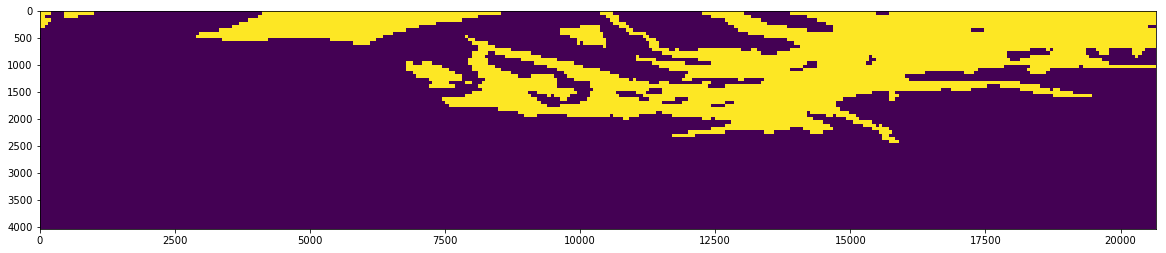

In [48]:
plt.figure(figsize=(20,20))
plt.imshow(np.flipud(grid_z0))

In [57]:
b = np.zeros_like(coherence_1)

In [58]:
grid_z0_uint8 = (grid_z0 * 255.999) .astype(np.uint8)  # right, Janna, not 256
b_uint8 = (b * 255.999) .astype(np.uint8)

In [61]:
rgb = np.dstack((coherence_1, np.flipud(grid_z0_uint8), b_uint8))  # stacks 3 h x w arrays -> h x w x 3

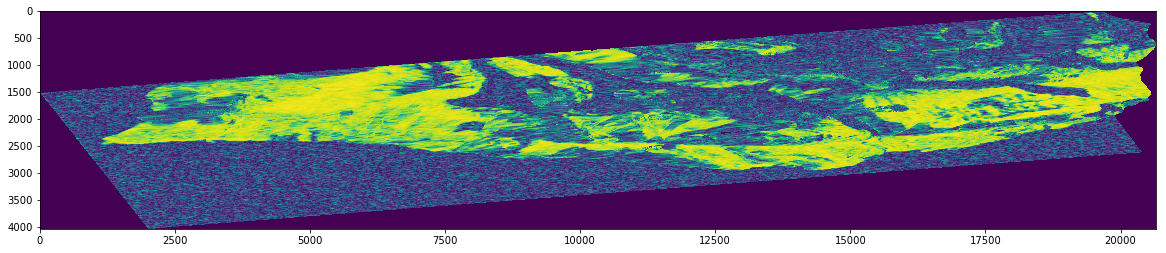

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(coherence_1)

In [80]:
test = np.copy(coherence_1)

In [81]:
test[np.flipud(grid_z0.astype(bool))] = 0

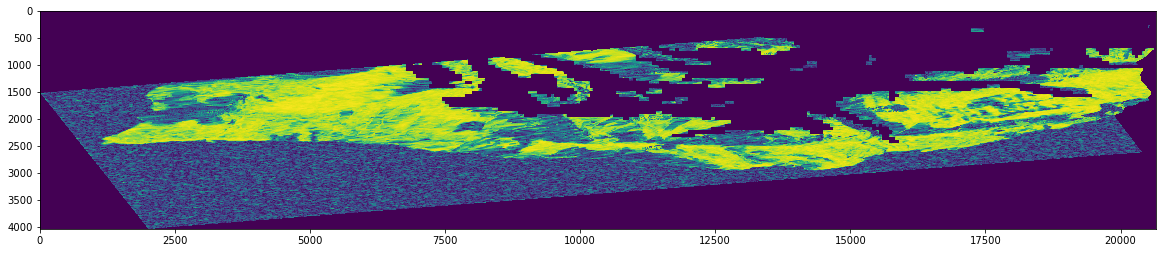

In [82]:
plt.figure(figsize=(20,20))
plt.imshow(test)

In [69]:
GT = test.GetGeoTransform()

In [ ]:
Xgeo = GT[0] + Xpixel*GT[1] + Yline*GT[2]
Ygeo = GT[3] + Xpixel*GT[4] + Yline*GT[5]